# Project Overview

### RQ1 : Transformer Encoder 기반 Machine-Generated Text Detection 방법에서 중요한 토큰이 존재하는가?
- Transformer Encoder based model (i.e. BERT, RoBERTa, etc.)을 사용한 기계 생성 텍스트 탐지에서 중요도가 높은 토큰 탐색

### RQ2 : 중요한 토큰에 마스킹을 적용해 paraphrasing을 적용하면 탐지 성능이 어떻게 변하는가?
- 중요도가 높은 토큰에 paraphrasing 적용한 예제에 대해 탐지 성능 평가

# Import Lib


In [8]:
import os
import json
import random
from typing import List

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import datasets
import transformers
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments, AutoTokenizer

from captum.attr import visualization as viz
from captum.attr import LayerConductance, LayerIntegratedGradients

from transformers_interpret import ZeroShotClassificationExplainer, MultiLabelClassificationExplainer, SequenceClassificationExplainer

import evaluate
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score


SEED = 0

# Load HC3 Data

## HC3 (Human ChatGPT Comparison Corpus)
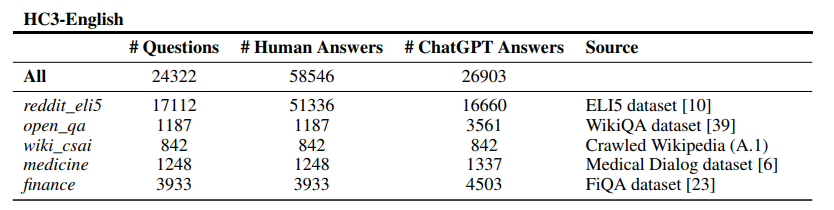

- [How Close is ChatGPT to Human Experts? Comparison Corpus, Evaluation, and Detection](https://arxiv.org/pdf/2301.07597) 논문에서 제안된 데이터셋
- HC3 English 데이터셋은 Finance, OpenQA, Wiki, Medicine, Reddit 과 같은 다양한 도메인의 24,000개의 질문에 대한 인간 및 ChatGPT 응답이 포함


[GitHub]
- https://github.com/Hello-SimpleAI/chatgpt-comparison-detection

In [3]:
def _preporcess_text(text):
    text = text.replace(
        '\n', '').replace(
        '\t', '').replace(
        '\r', '').replace(
        "\'", "").replace(
        '-', '').replace(
        '.', '').replace(
        ',', '').replace(
        '?', '').replace(
        '!', '').replace(
        '  ', ' ').replace(
        '   ', ' ').strip()
    
    return ' '.join(text.split())

def load_hc3(file_path:str) -> datasets.DatasetDict:
    """
    Load HC3 English Dataset to DatasetDict
    """
    data_list = []
    with open(file_path, 'r', encoding = 'utf-8') as file:
        for line in file:
            json_object = json.loads(line.strip())
            data_list.append(json_object)
        
    df = pd.DataFrame(data_list)
    df['human_answers'] = df['human_answers'].apply(lambda x: _preporcess_text(' '.join(x)))
    df['chatgpt_answers'] = df['chatgpt_answers'].apply(lambda x: _preporcess_text(' '.join(x)))
    
    df_human = {
        'text' : df['human_answers'].to_list(),
        'label' : [0] * len(df['human_answers'].to_list())
    }
    
    df_machine = {
        'text' : df['chatgpt_answers'].to_list(),
        'label' : [1] * len(df['chatgpt_answers'].to_list())
    }
    
    df_human = pd.DataFrame(df_human)
    df_machine = pd.DataFrame(df_machine)
    
    df = pd.concat([df_human, df_machine])
    df = df.reset_index(drop = True)
    
    data = datasets.Dataset.from_dict({'text' : df['text'].to_list(), 'label' : df['label'].to_list()})
    data = data.class_encode_column("label")
    
    return datasets.DatasetDict(data.train_test_split(train_size = 0.8, test_size = 0.2, shuffle = True, stratify_by_column = "label", seed = SEED))

In [4]:
# HC3 Finance Dataset
data = load_hc3('./data/HC3/finance.jsonl')
data


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 6292
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1574
    })
})

In [5]:
# 문장당 평균 단어 개수
total_word = 0
for text in data['train']['text']:
    total_word += len(text.split())

print(total_word/len(data['train']))

total_word = 0
for text in data['test']['text']:
    total_word += len(text.split())

print(total_word/len(data['test']))

203.97043865225683
205.42185514612453


# Train Model

## Implementaion Details
- Model : BERT
- Optimizer : AdamW
- Learning Rate : Temp
- Batch Size : Temp
- Epochs : Temp
- weight_decay = 0.01
- GPU : L40S or RTX 3060


In [6]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

def _compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average = 'binary')
    acc = accuracy_score(labels, preds)
    auc = roc_auc_score(labels, preds)
    return {
        "accuracy" : acc,
        "f1" : f1,
        "precision" : precision,
        "recall" : recall,
        'auroc' : auc
    }


def train_model(model_name: str, dataset_name: str,
                batch_size:int = 16,
                epoch:int = 2,
                learning_rate:float = 1e-4
                ):
    
    # load base model
    base_tokenizer = AutoTokenizer.from_pretrained(model_name, max_length = 512, padding = True, truncation = True)
    base_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels = 2).to(DEVICE)
    
    data = load_hc3(f'./data/HC3/{dataset_name}.jsonl')
    
    tokenized_data = data.map(lambda examples: base_tokenizer(examples['text'], truncation = True), batched = True)
    data_collator = transformers.DataCollatorWithPadding(tokenizer = base_tokenizer)

    # define training arguments
    # using AdamW optimizer
    training_args = transformers.TrainingArguments(
        output_dir = f'./bert_base_HC3_{dataset_name}',
        per_device_train_batch_size = batch_size,
        per_device_eval_batch_size = batch_size,
        learning_rate = learning_rate,
        weight_decay = 0.01,
        num_train_epochs = epoch,
        evaluation_strategy = "epoch",
        save_strategy = "epoch",
        load_best_model_at_end = True,
        logging_strategy = "steps",
        logging_steps = 100,
        seed = SEED
    )
    
    trainer = transformers.Trainer(
        model = base_model,
        tokenizer = base_tokenizer,
        args = training_args,
        train_dataset = tokenized_data['train'],
        eval_dataset = tokenized_data['test'],
        data_collator = data_collator,
        compute_metrics = _compute_metrics,
    )
    
    train_result = trainer.train()
    
    print("\n학습 결과:")
    print(f"Training Loss: {train_result.training_loss:.4f}")
    
    eval_results = trainer.evaluate()
    print("\n평가 데이터셋 성능:")
    print(f"Accuracy: {eval_results['eval_accuracy']:.4f}")
    print(f"F1 Score: {eval_results['eval_f1']:.4f}")
    print(f"Precision: {eval_results['eval_precision']:.4f}")
    print(f"Recall: {eval_results['eval_recall']:.4f}")
    print(f"AUROC: {eval_results['eval_auroc']:.4f}")

In [7]:
train_model(model_name = 'google-bert/bert-base-uncased', dataset_name = 'finance')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: dlehdgml1031. Use `wandb login --relogin` to force relogin


 13%|█▎        | 100/788 [06:02<42:04,  3.67s/it] 

{'loss': 0.4395, 'learning_rate': 8.730964467005075e-05, 'epoch': 0.25}


 25%|██▌       | 200/788 [11:56<32:04,  3.27s/it]

{'loss': 0.2288, 'learning_rate': 7.461928934010153e-05, 'epoch': 0.51}


 38%|███▊      | 300/788 [17:48<27:24,  3.37s/it]

{'loss': 0.1297, 'learning_rate': 6.192893401015228e-05, 'epoch': 0.76}


                                                 
 50%|█████     | 394/788 [26:25<17:10,  2.62s/it]

{'eval_loss': 0.21212245523929596, 'eval_accuracy': 0.9339263024142312, 'eval_f1': 0.9374247894103489, 'eval_precision': 0.8902857142857142, 'eval_recall': 0.9898348157560356, 'eval_auroc': 0.9339263024142312, 'eval_runtime': 178.1447, 'eval_samples_per_second': 8.836, 'eval_steps_per_second': 0.556, 'epoch': 1.0}


 51%|█████     | 400/788 [26:51<1:21:58, 12.68s/it]

{'loss': 0.2237, 'learning_rate': 4.9238578680203045e-05, 'epoch': 1.02}


 63%|██████▎   | 500/788 [33:01<17:00,  3.54s/it]  

{'loss': 0.0864, 'learning_rate': 3.654822335025381e-05, 'epoch': 1.27}


 76%|███████▌  | 600/788 [41:35<17:07,  5.47s/it]

{'loss': 0.0476, 'learning_rate': 2.385786802030457e-05, 'epoch': 1.52}


 89%|████████▉ | 700/788 [49:58<08:09,  5.56s/it]

{'loss': 0.0529, 'learning_rate': 1.116751269035533e-05, 'epoch': 1.78}


                                                 
100%|██████████| 788/788 [1:02:24<00:00,  3.60s/it]

{'eval_loss': 0.03104650042951107, 'eval_accuracy': 0.9930114358322745, 'eval_f1': 0.9930247305009512, 'eval_precision': 0.9911392405063291, 'eval_recall': 0.9949174078780177, 'eval_auroc': 0.9930114358322744, 'eval_runtime': 312.2021, 'eval_samples_per_second': 5.042, 'eval_steps_per_second': 0.317, 'epoch': 2.0}


100%|██████████| 788/788 [1:02:26<00:00,  4.75s/it]


{'train_runtime': 3755.4142, 'train_samples_per_second': 3.351, 'train_steps_per_second': 0.21, 'train_loss': 0.15518867621567042, 'epoch': 2.0}

학습 결과:
Training Loss: 0.1552


100%|██████████| 99/99 [03:24<00:00,  2.06s/it]


평가 데이터셋 성능:
Accuracy: 0.9930
F1 Score: 0.9930
Precision: 0.9911
Recall: 0.9949
AUROC: 0.9930


# Find Important Tokens

## Captum / Transformers-Interpret
- PyTorch 기반 기계 해석 라이브러리

### Captum
- https://captum.ai/

### transformers-interpret
- https://github.com/cdpierse/transformers-interpret

### Example
- https://captum.ai/tutorials/Bert_SQUAD_Interpret
- https://github.com/pytorch/captum/blob/master/tutorials/Bert_SQUAD_Interpret.ipynb
- https://github.com/pytorch/captum/issues/303

In [43]:
pretrained_model_path = './bert_base_HC3_finance/checkpoint-788'

tokenizer = AutoTokenizer.from_pretrained(pretrained_model_path)
model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_path)

cls_explainer = SequenceClassificationExplainer(model, tokenizer)

word_attributions = cls_explainer(data['test']['text'][3])

In [44]:
word_attributions

[('[CLS]', 0.0),
 ('there', -0.08833482172277582),
 ('are', 0.1457790951064184),
 ('several', 0.25280905176021223),
 ('risks', 0.27224644202958426),
 ('to', 0.11174086037158135),
 ('consider', 0.2022192347089975),
 ('when', 0.1946335839416819),
 ('buying', 0.15057299789011686),
 ('a', 0.1689472750337794),
 ('house', 0.04940872543760309),
 ('for', 0.019411989133779565),
 ('a', 0.03847713160934281),
 ('friend', 0.007976266526777406),
 ('and', 0.054229043726408646),
 ('then', -0.0005120823396901817),
 ('selling', 0.059114356422379076),
 ('it', 0.06018884188618695),
 ('back', 0.07663642658457337),
 ('to', 0.021727303807878847),
 ('them', -0.005281489743821162),
 ('##fin', 0.030223641920949156),
 ('##an', -0.0006728483640185486),
 ('##cial', 0.0019448131928333622),
 ('risk', 0.02590374896380595),
 (':', 0.3562553802232335),
 ('if', 0.0069289330451822555),
 ('your', 0.039096830412892886),
 ('friend', 0.014098130004227223),
 ('is', 0.013756097025659053),
 ('unable', 0.021457729635682734),
 ('

In [48]:
cls_explainer.visualize()

# Paraphrasing Important Tokens

In [ ]:
# 작성 예정

# Evaluate Paraphrased Texts


In [ ]:
# 작성 예정